In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
%matplotlib inline

In [2]:
def create_and_train_autoencoder(input_data, epochs=10, batch_size=32):
    input_layer = Input(shape=(1,))
    encoded = Dense(64, activation='relu')(input_layer)
    decoded = Dense(1, activation='linear')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    history = autoencoder.fit(input_data, input_data, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)
    
    print("Training Information:")
    print(f"Number of training epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    
    history = autoencoder.history.history
    
    print("\nTraining Metrics:")
    for metric_name, values in history.items():
        print(f"{metric_name}: {values[-1]}")
        
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return autoencoder, autoencoder.layers[1]

In [3]:
def generate_embeddings_around_time(ecg_data, time_x, sample_rate, embedding_size=32, time_window=2):
    x_index = int(time_x * sample_rate)
    data_x = ecg_data[x_index - time_window * sample_rate : x_index + time_window * sample_rate]
    data_x_reshaped = data_x.reshape(-1, 1)

    autoencoder, encoder = create_and_train_autoencoder(data_x_reshaped)
    
    encoder_model = keras.models.Model(inputs=autoencoder.input, outputs=encoder(autoencoder.input))
    
    embeddings_x = encoder_model.predict(data_x_reshaped)
    
    reconstructed_data = autoencoder.predict(data_x_reshaped)
    
    return embeddings_x, reconstructed_data


Epoch 1/10
44/44 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0147
Epoch 2/10
44/44 [==============================] - 0s 962us/step - loss: 0.0063 - val_loss: 0.0031
Epoch 3/10
44/44 [==============================] - 0s 935us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 4/10
44/44 [==============================] - 0s 664us/step - loss: 8.8594e-04 - val_loss: 7.1308e-04
Epoch 5/10
44/44 [==============================] - 0s 681us/step - loss: 5.1233e-04 - val_loss: 4.7618e-04
Epoch 6/10
44/44 [==============================] - 0s 754us/step - loss: 3.2491e-04 - val_loss: 3.4916e-04
Epoch 7/10
44/44 [==============================] - 0s 651us/step - loss: 2.2029e-04 - val_loss: 2.4364e-04
Epoch 8/10
44/44 [==============================] - 0s 683us/step - loss: 1.5352e-04 - val_loss: 1.8343e-04
Epoch 9/10
44/44 [==============================] - 0s 689us/step - loss: 1.0723e-04 - val_loss: 1.4163e-04
Epoch 10/10
44/44 [==============================] - 0

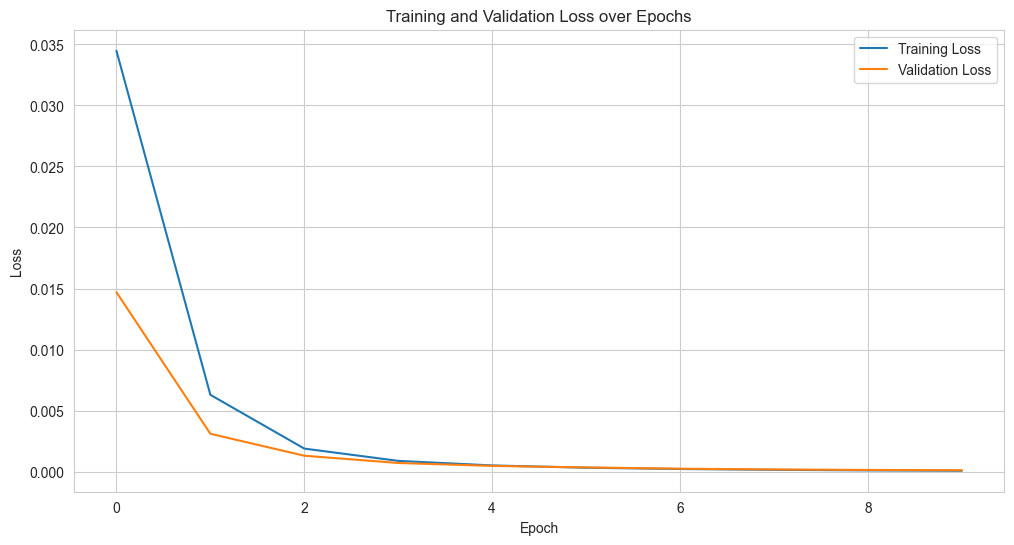

63/63 [==============================] - 0s 270us/step


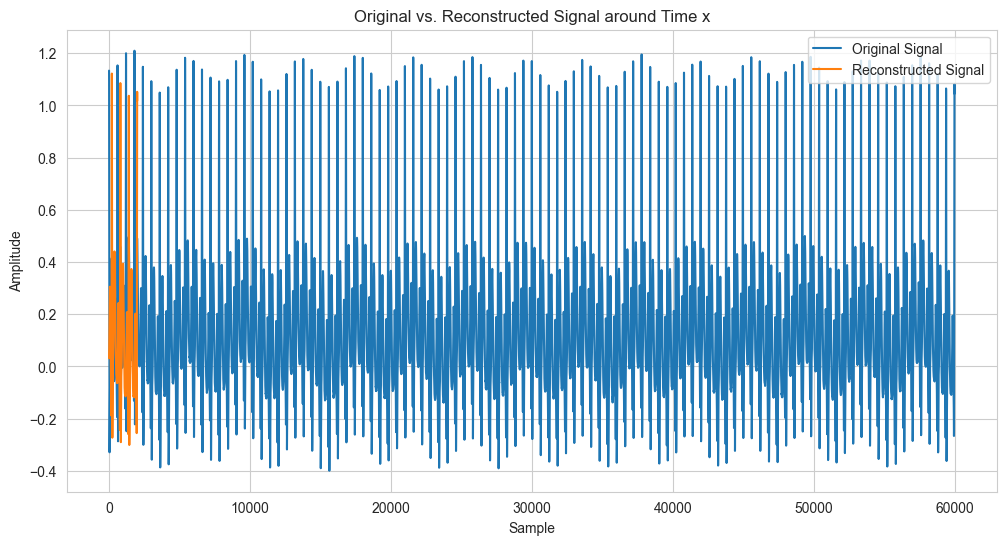

In [4]:
duration_minutes = 1
sample_rate = 1000
ecg_signal = nk.ecg_simulate(duration=duration_minutes * 60, noise=0.01, heart_rate=100)

time_x_user = 1 * 60

embeddings_x_user, reconstructed_data_user = generate_embeddings_around_time(ecg_signal, time_x_user, sample_rate=sample_rate)

plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label='Original Signal')
plt.plot(reconstructed_data_user, label='Reconstructed Signal')

index_to_plot = int(time_x_user * sample_rate)
if index_to_plot < len(reconstructed_data_user):
    plt.scatter(index_to_plot, reconstructed_data_user[index_to_plot], color='red', label='Time x')

plt.title('Original vs. Reconstructed Signal around Time x')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [5]:
print("Embeddings no tempo x:", embeddings_x_user)

Embeddings no tempo x: [[0.         0.0831115  0.         ... 0.         0.06348856 0.0620824 ]
 [0.         0.08366479 0.         ... 0.         0.0642294  0.0625703 ]
 [0.         0.08424755 0.         ... 0.         0.06500971 0.0630842 ]
 ...
 [0.         0.3510913  0.         ... 0.         0.42230833 0.29839393]
 [0.         0.34793064 0.         ... 0.         0.41807628 0.2956068 ]
 [0.         0.34263787 0.         ... 0.         0.41098934 0.29093948]]


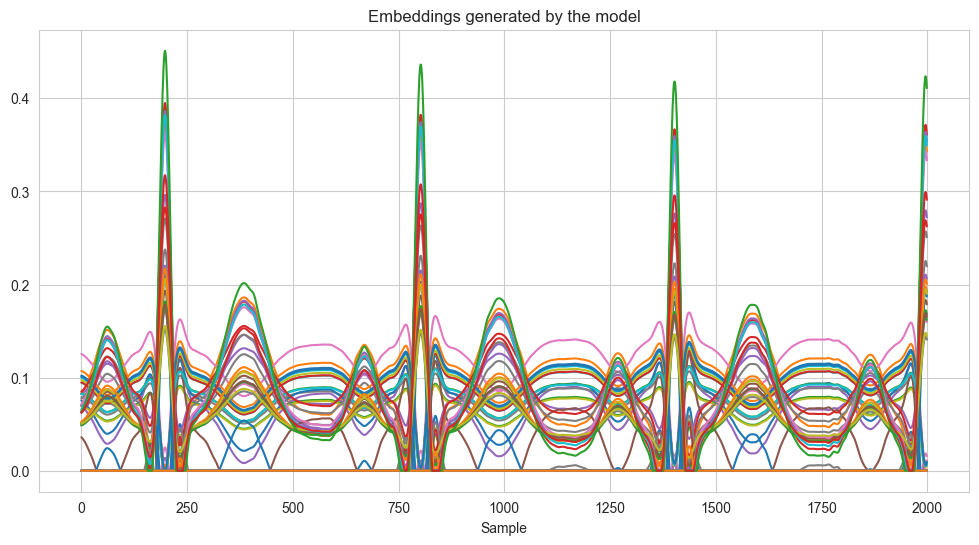

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(embeddings_x_user)
plt.title('Embeddings generated by the model')
plt.xlabel('Sample')
plt.show()